# Team 11 Python Programming Term Project

In [1]:
import pandas as pd
import numpy as np
from imblearn.over_sampling import SMOTE
import scipy as sp 
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import (GroupKFold, GroupShuffleSplit, cross_validate, 
                                       RandomizedSearchCV,GridSearchCV)
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')

In [2]:
# To read data
df = pd.read_csv('simulated_TECHCO_data.csv') 

# Descriptive Analysis

In [3]:
df.head()

,time,training_score,logical_score,verbal_score,avg_literacy,location_age,distance,similar_language,is_male,emp_id,turnover
0,1,4.840446,5,2,81.05207,6,1.635494,24.11053,1,1,Stayed
1,2,4.840446,5,2,81.05207,6,1.635494,24.11053,1,1,Stayed
2,3,4.840446,5,2,81.05207,6,1.635494,24.11053,1,1,Stayed
3,4,4.840446,5,2,81.05207,6,1.635494,24.11053,1,1,Stayed
4,5,4.840446,5,2,81.05207,6,1.635494,24.11053,1,1,Stayed


In [4]:
# Number of rows and columns
df.shape 

(34452, 11)

In [5]:
# Returns the column names
df.columns 

Index(['time', 'training_score', 'logical_score', 'verbal_score',
       'avg_literacy', 'location_age', 'distance', 'similar_language',
       'is_male', 'emp_id', 'turnover'],
      dtype='object')

In [6]:
# How many entries a dataframe has  (including null entries)
df.size 

378972

In [7]:
df.dtypes

time                  int64
training_score      float64
logical_score         int64
verbal_score          int64
avg_literacy        float64
location_age          int64
distance            float64
similar_language    float64
is_male               int64
emp_id                int64
turnover             object
dtype: object

In [8]:
numerical_var = list(df.select_dtypes(exclude=object).columns) 
# Filtering columns that are only numerical
numerical_var

['time',
 'training_score',
 'logical_score',
 'verbal_score',
 'avg_literacy',
 'location_age',
 'distance',
 'similar_language',
 'is_male',
 'emp_id']

In [9]:
categorical_var =  list(df.select_dtypes(object).columns) 
# Filtering columns that are only categorical variables 
categorical_var

['turnover']

In [10]:
df_last = df.groupby('emp_id', as_index=False).last()
# To group by employee id showing only the last record, removing duplicates 
df_last

,emp_id,time,training_score,logical_score,verbal_score,avg_literacy,location_age,distance,similar_language,is_male,turnover
0,1,39,4.840446,5,2,81.05207,6,1.635494,24.11053,1,Stayed
1,2,34,4.355449,0,8,93.72386,3,0.234684,96.08640,1,Stayed
2,3,37,4.416302,3,2,66.49519,6,0.673065,100.00000,1,Stayed
3,4,34,4.995522,11,3,87.05980,13,0.232718,93.20673,1,Stayed
4,5,33,4.531571,1,0,77.78675,24,2.333878,23.03190,0,Stayed
...,...,...,...,...,...,...,...,...,...,...,...
1186,1187,34,4.895838,1,3,80.50422,9,0.514864,100.00000,0,Stayed
1187,1188,39,4.503906,0,0,56.55196,12,2.422109,37.59651,1,Left
1188,1189,29,4.945488,6,7,59.76929,27,2.265522,32.94450,0,Left
1189,1190,6,2.829304,7,5,66.10549,10,1.346729,15.10681,0,Left


In [11]:
df_last.shape

(1191, 11)

In [12]:
# Count of employees who stayed or left
pd.pivot_table(df_last, values='time', index=['turnover'], aggfunc = 'count')

,time
turnover,
Left,494
Stayed,697


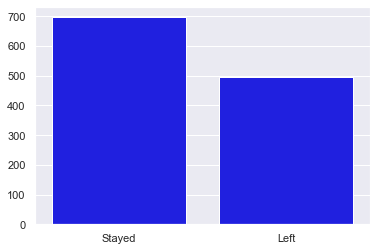

In [13]:
# Stayed vs left employees
sns.set(style="darkgrid") 
ax = sns.barplot(x=df_last['turnover'].value_counts().index, 
                 y=df_last['turnover'].value_counts().values, 
                 color = 'blue') 

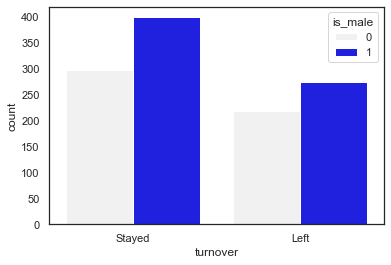

In [14]:
# Stayed vs left employees, hue for gender
sns.set(style="white")
ax = sns.countplot(x='turnover', hue = 'is_male', data = df_last,
                  color = 'Blue')

In [15]:
# Check if there are any variables with zero variance
df_last.std()

emp_id              343.956393
time                 10.982440
training_score        0.544875
logical_score         3.928876
verbal_score          4.438657
avg_literacy          9.273565
location_age          7.939056
distance              0.750328
similar_language     35.303239
is_male               0.495845
dtype: float64

In [16]:
# Statistically summarizing the dataframe
df_last.describe()

,emp_id,time,training_score,logical_score,verbal_score,avg_literacy,location_age,distance,similar_language,is_male
count,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000,1191.000000
mean,596.000000,28.926952,4.392502,4.473552,4.649874,75.712149,15.222502,0.816037,59.643230,0.565911
std,343.956393,10.982440,0.544875,3.928876,4.438657,9.273565,7.939056,0.750328,35.303239,0.495845
min,1.000000,1.000000,2.688673,-5.000000,-7.000000,49.354540,2.000000,0.000000,1.250000,0.000000
25%,298.500000,24.000000,4.171338,1.000000,1.000000,68.657835,9.000000,0.199370,27.170575,0.000000
50%,596.000000,34.000000,4.524776,4.000000,4.000000,77.161420,11.000000,0.579961,55.704960,1.000000
75%,893.500000,37.000000,4.809570,8.000000,7.000000,82.838030,24.000000,1.251390,98.798635,1.000000
max,1191.000000,39.000000,5.110679,12.000000,17.000000,97.357410,28.000000,3.200019,100.000000,1.000000


In [17]:
df_last.mode()[:1]

,emp_id,time,training_score,logical_score,verbal_score,avg_literacy,location_age,distance,similar_language,is_male,turnover
0,1,37.0,4.682977,0.0,0.0,83.58855,10.0,0.0,100.0,1.0,Stayed


In [18]:
df_last.median()

emp_id              596.000000
time                 34.000000
training_score        4.524776
logical_score         4.000000
verbal_score          4.000000
avg_literacy         77.161420
location_age         11.000000
distance              0.579961
similar_language     55.704960
is_male               1.000000
dtype: float64

In [19]:
# Create a DataFrame indicating which values are missing
missing_value_df = df.isnull()

# Calculate the percentage of missing values for each column
percent_missing = missing_value_df.mean()
percent_missing

time                0.0
training_score      0.0
logical_score       0.0
verbal_score        0.0
avg_literacy        0.0
location_age        0.0
distance            0.0
similar_language    0.0
is_male             0.0
emp_id              0.0
turnover            0.0
dtype: float64

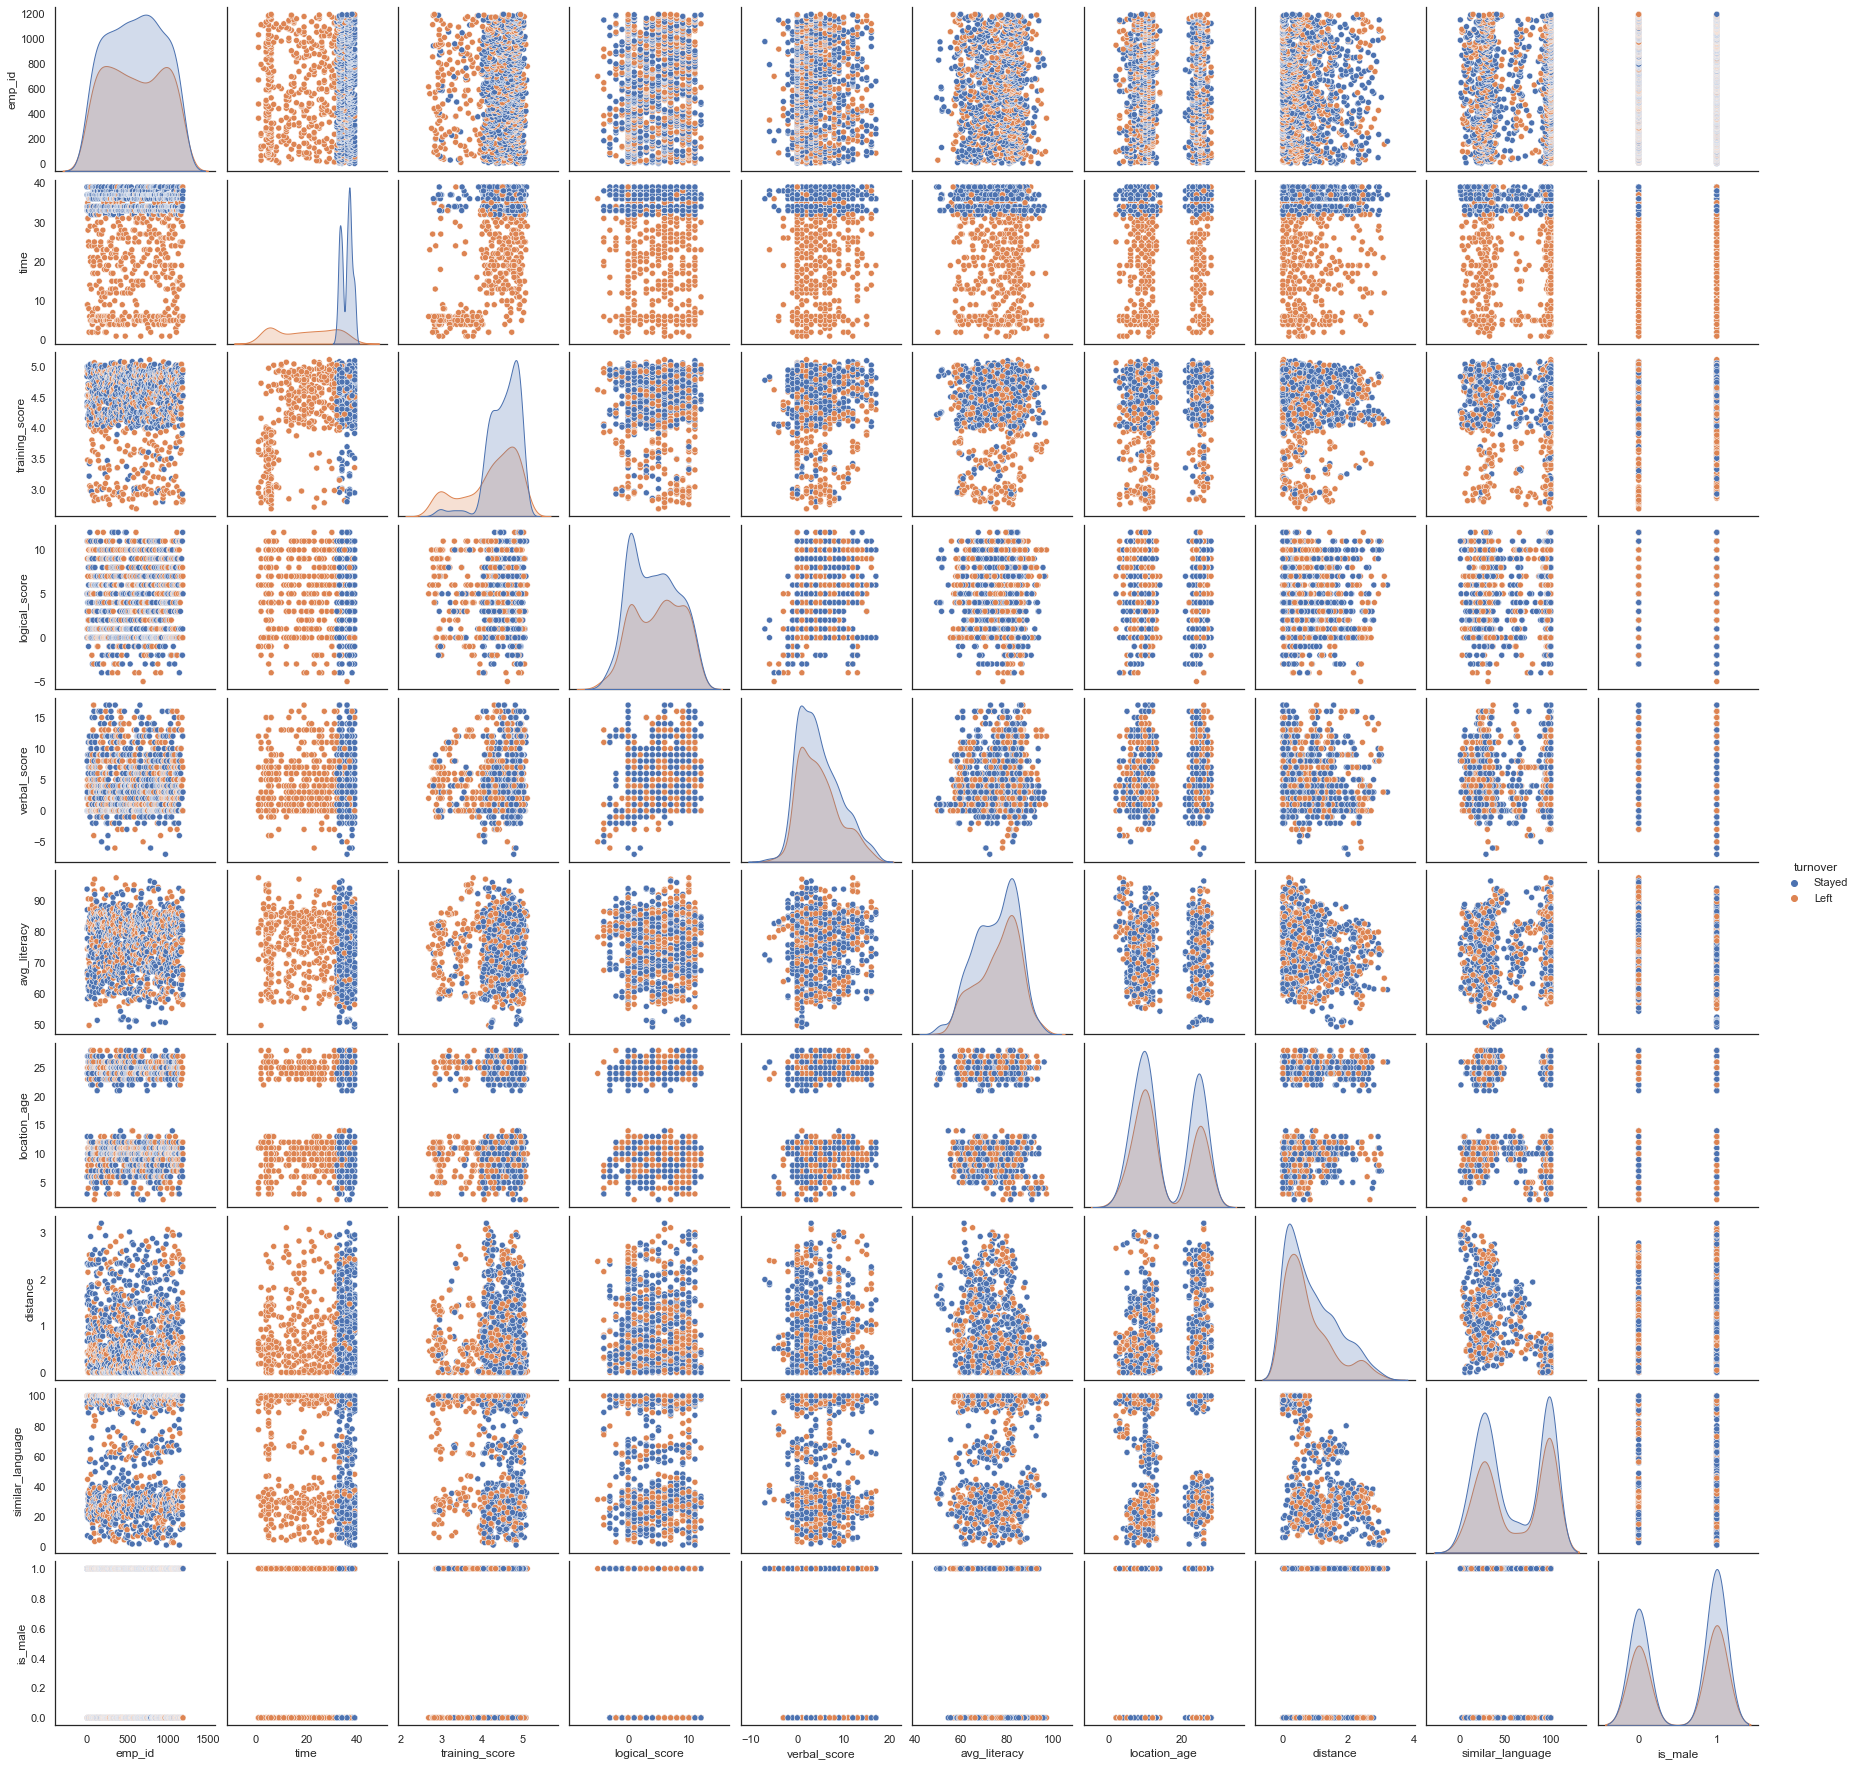

In [20]:
# Creates a correlation matrix 
# Where the diagonal axis contains histograms
g = sns.pairplot(df_last, hue = 'turnover')

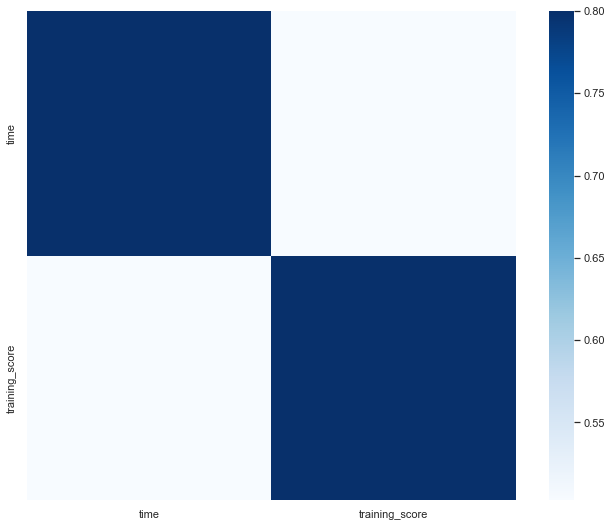

In [21]:
# Correlation matrix

# Computes the correlation among variables
corrmat = df_last.corr() 

# Returns highly correlated variables
high_c = corrmat[corrmat['time'].abs()>0.5].index

# Plots a correlation plot
f, ax = plt.subplots(figsize=(12, 9)) 
# Determines the figure size
ax = sns.heatmap(corrmat.loc[high_c, high_c], vmax=.8, square=True, cmap="Blues") # creates a heatmap using the correlation matrix

# Data Preprocessing

In [22]:
# Checks if there is any variables with zero variance
df_last.std() 

emp_id              343.956393
time                 10.982440
training_score        0.544875
logical_score         3.928876
verbal_score          4.438657
avg_literacy          9.273565
location_age          7.939056
distance              0.750328
similar_language     35.303239
is_male               0.495845
dtype: float64

In [23]:
# Scaling
# Extracts the numerical values
numerical_val = set(df_last.columns) - set(df_last.dtypes[df_last.dtypes == object].index)
numerical_val = list(numerical_val - set(['is_male']))
categorical_val = list(set(df.dtypes[df.dtypes == object].index) - set(['is_male']))
# Imports the preprocessing library
from sklearn import preprocessing 

# Converts pandas df to numpy array
array = df_last[numerical_val].values 

# Creates a min max scaler
data_scaler = preprocessing.MinMaxScaler(feature_range=(0,1)) 

# Scales the data and overwrites it into the existing dataframe
df_last[numerical_val] = pd.DataFrame(data_scaler.fit_transform(array), 
                                 columns = numerical_val) 
df_last.head() 

,emp_id,time,training_score,logical_score,verbal_score,avg_literacy,location_age,distance,similar_language,is_male,turnover
0,0.000000,1.000000,0.888426,0.588235,0.375000,0.660326,0.153846,0.511089,0.231499,1,Stayed
1,0.000840,0.868421,0.688180,0.294118,0.625000,0.924306,0.038462,0.073338,0.960369,1,Stayed
2,0.001681,0.947368,0.713305,0.470588,0.375000,0.357076,0.153846,0.210331,1.000000,1,Stayed
3,0.002521,0.868421,0.952454,0.941176,0.416667,0.785479,0.423077,0.072724,0.931207,1,Stayed
4,0.003361,0.842105,0.760897,0.352941,0.291667,0.592302,0.846154,0.729333,0.220576,0,Stayed


In [24]:
# Standardization
# Imports the StandardScaler module from sklearn
from sklearn.preprocessing import StandardScaler 

# Creates a column names for standardized values
new_col = [i+'_standardized' for i in numerical_val] 


# Converts the df[numerical_val] to numpy array
array = df_last[numerical_val].values 


# Creates standarization instance
data_scaler = StandardScaler().fit(array) 


# Standardize the numerical variables
df_last[new_col] = pd.DataFrame(data_scaler.transform(array))

df_last = df_last.drop(numerical_val, axis = 1)
df_last.head()

,is_male,turnover,time_standardized,distance_standardized,similar_language_standardized,verbal_score_standardized,avg_literacy_standardized,location_age_standardized,emp_id_standardized,training_score_standardized,logical_score_standardized
0,1,Stayed,0.917581,1.092591,-1.006923,-0.597250,0.576064,-1.162150,-1.730597,0.822448,0.134051
1,1,Stayed,0.462118,-0.775124,1.032723,0.755078,1.943080,-1.540188,-1.727689,-0.068032,-1.139112
2,1,Stayed,0.735396,-0.190626,1.143627,-0.597250,-0.994314,-1.162150,-1.724780,0.043698,-0.375214
3,1,Stayed,0.462118,-0.777744,0.951120,-0.371862,1.224170,-0.280063,-1.721871,1.107176,1.661847
4,0,Stayed,0.371025,2.023754,-1.037489,-1.048026,0.223805,1.106074,-1.718963,0.255338,-0.884480


In [25]:
# Example to convert categorical variables into dummy variables
categorical_var = list(df_last.dtypes[df_last.dtypes == object].index)

# Create dummy variables using onehot encoding
dummy_cat_df = pd.get_dummies(df_last[categorical_var], drop_first=True) 

# Drops categorical variables from the df
df_last = df_last.drop(categorical_var, axis = 1) 

# Adds the newly created dummy variables instead
df_last = pd.concat([df_last, dummy_cat_df], axis = 1) 

df_last.head()

,is_male,time_standardized,distance_standardized,similar_language_standardized,verbal_score_standardized,avg_literacy_standardized,location_age_standardized,emp_id_standardized,training_score_standardized,logical_score_standardized,turnover_Stayed
0,1,0.917581,1.092591,-1.006923,-0.597250,0.576064,-1.162150,-1.730597,0.822448,0.134051,1
1,1,0.462118,-0.775124,1.032723,0.755078,1.943080,-1.540188,-1.727689,-0.068032,-1.139112,1
2,1,0.735396,-0.190626,1.143627,-0.597250,-0.994314,-1.162150,-1.724780,0.043698,-0.375214,1
3,1,0.462118,-0.777744,0.951120,-0.371862,1.224170,-0.280063,-1.721871,1.107176,1.661847,1
4,0,0.371025,2.023754,-1.037489,-1.048026,0.223805,1.106074,-1.718963,0.255338,-0.884480,1


In [26]:
df_last['turnover_Stayed'].value_counts()

1    697
0    494
Name: turnover_Stayed, dtype: int64

In [27]:
df_last.describe()

,is_male,time_standardized,distance_standardized,similar_language_standardized,verbal_score_standardized,avg_literacy_standardized,location_age_standardized,emp_id_standardized,training_score_standardized,logical_score_standardized,turnover_Stayed
count,1191.000000,1.191000e+03,1.191000e+03,1.191000e+03,1.191000e+03,1.191000e+03,1.191000e+03,1.191000e+03,1.191000e+03,1.191000e+03,1191.000000
mean,0.565911,1.062682e-16,-1.119545e-16,-1.617327e-16,-1.931937e-16,-3.326008e-16,3.514308e-16,1.379622e-17,-1.390575e-16,1.185263e-16,0.585223
std,0.495845,1.000420e+00,1.000420e+00,1.000420e+00,1.000420e+00,1.000420e+00,1.000420e+00,1.000420e+00,1.000420e+00,1.000420e+00,0.492891
min,0.000000,-2.543941e+00,-1.088031e+00,-1.654742e+00,-2.625742e+00,-2.843425e+00,-1.666200e+00,-1.730597e+00,-3.128321e+00,-2.412276e+00,0.000000
25%,0.000000,-4.488094e-01,-8.222087e-01,-9.202072e-01,-8.226378e-01,-7.610102e-01,-7.841129e-01,-8.652986e-01,-4.060693e-01,-8.844797e-01,0.000000
50%,1.000000,4.621176e-01,-3.147622e-01,-1.116023e-01,-1.464738e-01,1.563454e-01,-5.320880e-01,0.000000e+00,2.428615e-01,-1.205817e-01,1.000000
75%,1.000000,7.353957e-01,5.804618e-01,1.109582e+00,5.296902e-01,7.687307e-01,1.106074e+00,8.652986e-01,7.657593e-01,8.979489e-01,1.000000
max,1.000000,9.175811e-01,3.178589e+00,1.143627e+00,2.783570e+00,2.335063e+00,1.610124e+00,1.730597e+00,1.318610e+00,1.916480e+00,1.000000


In [28]:
# Z score
from scipy import stats
import numpy as np

z = np.abs(stats.zscore(df_last))
outliers = z > 3
print(outliers)


      is_male  time_standardized  distance_standardized  \
0       False              False                  False   
1       False              False                  False   
2       False              False                  False   
3       False              False                  False   
4       False              False                  False   
...       ...                ...                    ...   
1186    False              False                  False   
1187    False              False                  False   
1188    False              False                  False   
1189    False              False                  False   
1190    False              False                  False   

      similar_language_standardized  verbal_score_standardized  \
0                             False                      False   
1                             False                      False   
2                             False                      False   
3                          

In [29]:
# Using the smote technique 
import imblearn
from imblearn.over_sampling import SMOTE

# (somehow oversampling) to balance the data
os = SMOTE(random_state=0) 

# Sets the input var
input_var = list(set(df_last.columns) - set(['turnover_Stayed'])) 

# Oversamples the data
X, Y = os.fit_resample(df_last[df_last.columns.difference(['turnover_Stayed'])], df_last['turnover_Stayed']) 
# Makes the X array as a dataframe
X = pd.DataFrame(X, columns = input_var) 
# Makes the Y array as a dataframe
Y = pd.DataFrame(Y, columns = ['turnover_Stayed']) 

# Combine X and Y
df_last = pd.concat([X, Y], axis=1) 
df_last

,time_standardized,training_score_standardized,similar_language_standardized,verbal_score_standardized,distance_standardized,location_age_standardized,is_male,avg_literacy_standardized,emp_id_standardized,logical_score_standardized,turnover_Stayed
0,0.917581,0.822448,-1.006923,-0.597250,1.092591,-1.162150,1,0.576064,-1.730597,0.134051,1
1,0.462118,-0.068032,1.032723,0.755078,-0.775124,-1.540188,1,1.943080,-1.727689,-1.139112,1
2,0.735396,0.043698,1.143627,-0.597250,-0.190626,-1.162150,1,-0.994314,-1.724780,-0.375214,1
3,0.462118,1.107176,0.951120,-0.371862,-0.777744,-0.280063,1,1.224170,-1.721871,1.661847,1
4,0.371025,0.255338,-1.037489,-1.048026,2.023754,1.106074,0,0.223805,-1.718963,-0.884480,1
...,...,...,...,...,...,...,...,...,...,...,...
1389,0.315063,0.257173,1.136956,0.838158,-0.666567,1.453146,0,1.042726,-1.303028,-0.339587,0
1390,-0.753586,-0.234853,-0.943040,0.571819,-0.274528,-1.091488,1,0.960255,-1.465428,0.181647,0
1391,-0.471327,0.307080,-0.901545,0.045695,0.285609,1.448965,0,-1.681681,0.552147,0.643316,0
1392,-0.895318,0.835049,1.143627,-0.822638,-0.566675,-0.969757,1,-1.229544,-0.706035,0.388684,0


In [30]:
df_last['turnover_Stayed'].value_counts()

1    697
0    697
Name: turnover_Stayed, dtype: int64

<AxesSubplot:>

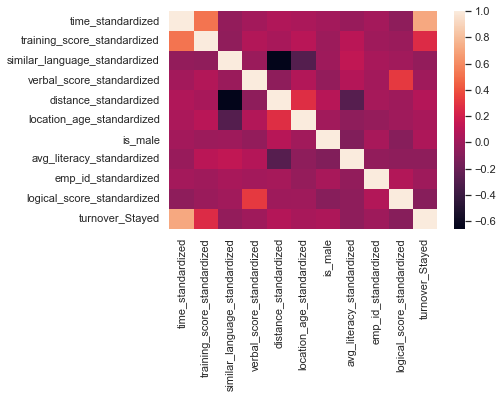

In [31]:
import seaborn as sns
from seaborn import heatmap

# Calculate the pairwise correlations between all columns
corr_matrix = df_last.corr()
correlations = df_last.corr()

# Create a heatmap of the correlations using the corrplot function
heatmap(correlations)

In [32]:
import seaborn as sns

# Calculate the pairwise correlations between all columns
corr_matrix = df_last.corr()

# Create a heatmap of the correlations using the corrplot function
corr_matrix

,time_standardized,training_score_standardized,similar_language_standardized,verbal_score_standardized,distance_standardized,location_age_standardized,is_male,avg_literacy_standardized,emp_id_standardized,logical_score_standardized,turnover_Stayed
time_standardized,1.000000,0.518934,-0.044886,0.015175,0.062614,0.044012,0.013290,-0.028508,0.022952,-0.064862,0.710819
training_score_standardized,0.518934,1.000000,-0.060774,0.072149,0.033434,0.097534,-0.011331,0.103388,-0.000437,-0.016652,0.261164
similar_language_standardized,-0.044886,-0.060774,1.000000,-0.018296,-0.656223,-0.292289,-0.004065,0.129651,0.033590,0.007667,-0.048034
verbal_score_standardized,0.015175,0.072149,-0.018296,1.000000,-0.063381,0.073595,-0.047180,0.080017,0.011420,0.315893,0.000336
distance_standardized,0.062614,0.033434,-0.656223,-0.063381,1.000000,0.270503,0.092527,-0.285284,0.023225,-0.007199,0.075208
location_age_standardized,0.044012,0.097534,-0.292289,0.073595,0.270503,1.000000,0.004396,-0.063287,-0.035345,0.002006,0.033396
is_male,0.013290,-0.011331,-0.004065,-0.047180,0.092527,0.004396,1.000000,-0.119205,0.032696,-0.088864,0.051876
avg_literacy_standardized,-0.028508,0.103388,0.129651,0.080017,-0.285284,-0.063287,-0.119205,1.000000,-0.050947,-0.065278,-0.065218
emp_id_standardized,0.022952,-0.000437,0.033590,0.011420,0.023225,-0.035345,0.032696,-0.050947,1.000000,0.070345,-0.007506
logical_score_standardized,-0.064862,-0.016652,0.007667,0.315893,-0.007199,0.002006,-0.088864,-0.065278,0.070345,1.000000,-0.088640


<AxesSubplot:>

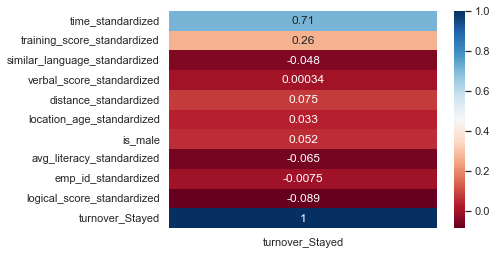

In [33]:
import seaborn as sns

# Calculate the pairwise correlations between all columns
corr_matrix = df_last.corr()

# Select the column for which you want to create a heatmap of the correlations
column = 'turnover_Stayed'

# Create a DataFrame containing only the correlations for the selected column
corr_df = corr_matrix[[column]]

# Create a heatmap of the correlations using the corrplot function
sns.heatmap(corr_df, cmap='RdBu', annot=True)


In [34]:
# Calculate the pairwise correlations between all columns
corr_matrix = df_last.corr()

# Select the columns to keep in the DataFrame
columns_to_keep = []

# Iterate over the columns in the DataFrame
for col in df_last.columns:
  # Check if the column has any highly correlated columns
  highly_correlated = (abs(corr_matrix[col]) > 0.8) & (corr_matrix[col] != 1)
  if not highly_correlated.any():
    # If the column does not have any highly correlated columns, keep it in the DataFrame
    columns_to_keep.append(col)

# Create a new DataFrame with only the selected columns
df = df_last[columns_to_keep]
df

,time_standardized,training_score_standardized,similar_language_standardized,verbal_score_standardized,distance_standardized,location_age_standardized,is_male,avg_literacy_standardized,emp_id_standardized,logical_score_standardized,turnover_Stayed
0,0.917581,0.822448,-1.006923,-0.597250,1.092591,-1.162150,1,0.576064,-1.730597,0.134051,1
1,0.462118,-0.068032,1.032723,0.755078,-0.775124,-1.540188,1,1.943080,-1.727689,-1.139112,1
2,0.735396,0.043698,1.143627,-0.597250,-0.190626,-1.162150,1,-0.994314,-1.724780,-0.375214,1
3,0.462118,1.107176,0.951120,-0.371862,-0.777744,-0.280063,1,1.224170,-1.721871,1.661847,1
4,0.371025,0.255338,-1.037489,-1.048026,2.023754,1.106074,0,0.223805,-1.718963,-0.884480,1
...,...,...,...,...,...,...,...,...,...,...,...
1389,0.315063,0.257173,1.136956,0.838158,-0.666567,1.453146,0,1.042726,-1.303028,-0.339587,0
1390,-0.753586,-0.234853,-0.943040,0.571819,-0.274528,-1.091488,1,0.960255,-1.465428,0.181647,0
1391,-0.471327,0.307080,-0.901545,0.045695,0.285609,1.448965,0,-1.681681,0.552147,0.643316,0
1392,-0.895318,0.835049,1.143627,-0.822638,-0.566675,-0.969757,1,-1.229544,-0.706035,0.388684,0


In [35]:
# Select the column to check for repeated values
column = df_last['emp_id_standardized']

# Count the number of unique values in the column
num_unique_values = column.nunique()

# Count the total number of values in the column
num_total_values = column.count()

# Check if there are any repeated values in the column
if num_unique_values < num_total_values:
  print('There are repeated values in the column.')
else:
  print('There are no repeated values in the column.')

There are no repeated values in the column.


In [36]:
mean_t = df_last['time_standardized'].mean()
mean_tr= df_last['training_score_standardized'].mean()

In [37]:
std_t = df_last['time_standardized'].std()
std_tr= df_last['training_score_standardized'].std()

In [38]:
# To improve fitting models removed the low corelated var
df_last = df_last[['time_standardized', 'training_score_standardized','turnover_Stayed']]

# Fitting a Models

In [39]:
target = 'turnover_Stayed'
from sklearn.linear_model import LinearRegression

# Determines the input variables
input_col = list(set(df_last.columns) - set(['turnover_Stayed']))  

# Creates a linear regression instance
model = LinearRegression() 

# Fits the data to find the model coeffs
model.fit(df_last[input_col], df_last[target]) 

# Prints the model coefficients
print('Model coefficients:') 
print(model.coef_)

# Prints the R2 value which shows the percent of variance explained by the model
# 100% is a perfect model
# 0 is useles

print('\n')

print('R2 value: ' + str(round(100*model.score(df_last[input_col], 
                                               df_last[target]), 2)))
print('\n')


# Builds a new dataframe that will contain the actual target values
# predicted target values variables
# and Error (Residuals) (Actual - Target)
# Note that the higher the error the worse the model
# Higher the R2, better the model

pred_vs_actual = pd.DataFrame()
pred_vs_actual['actual'] = df_last[target]
pred_vs_actual['predicted'] = np.round(model.predict(df_last[input_col]), 0)
pred_vs_actual['error'] = pred_vs_actual['actual'] - pred_vs_actual['predicted']
print(pred_vs_actual.head())

Model coefficients:
[ 0.3863672  -0.07194487]


R2 value: 52.11


   actual  predicted  error
0       1        1.0    0.0
1       1        1.0    0.0
2       1        1.0    0.0
3       1        1.0    0.0
4       1        1.0    0.0


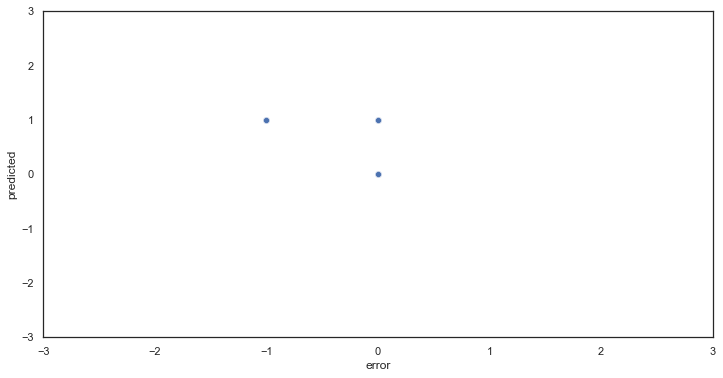

In [40]:
# Assesing the model
fig, ax = plt.subplots(figsize=(12,6)) # Determines the figure size
ax = sns.scatterplot(x='error', y='predicted', data=pred_vs_actual) 
# plots the error vs. predicted
limits = ax.set(xlim=(-3, 3), ylim=(-3, 3)) #sets the limit for x and y axis

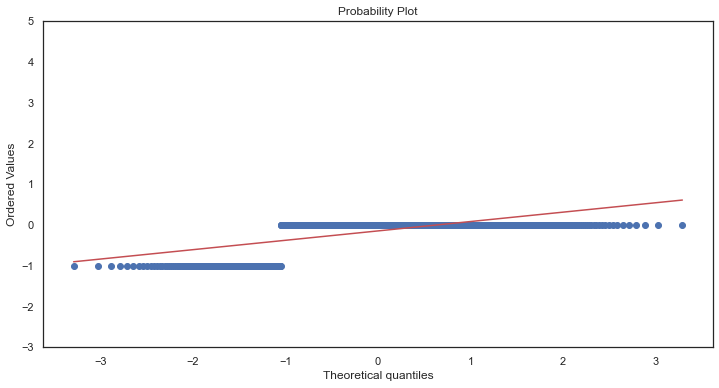

In [41]:
# Determines the figure size
fig, ax = plt.subplots(figsize=(12,6)) 

# Generates the normality plot
_, (__, ___, r) = sp.stats.probplot(pred_vs_actual['error'], plot=ax, fit=True) 

# Sets the limits for the graph
limits = ax.set(ylim=(-3, 5)) 

In [42]:
input_var  = set(df_last.columns) - set(['turnover_Stayed'])
X = df_last[input_var]
Y = df_last['turnover_Stayed']

In [43]:
models = ['LogisticReg', 'DecisionTree', 'RandomForest', 'KNN'] # models that will be built
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
# Logistic Regression
lr = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr') # creates a lR instance
lr.fit(X_train, Y_train)
# Decision Trees
dt = DecisionTreeClassifier(criterion = 'gini', splitter='best', max_depth=15)
dt.fit(X_train, Y_train)
# Random Forests
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0)
rf.fit(X_train, Y_train)
# K-NN
knn = KNeighborsClassifier(n_neighbors = 5)
knn.fit(X_train, Y_train)

KNeighborsClassifier()

In [44]:
# Computes the confusion matrix and performance indicators
def get_performance(actual_Y, pred_Y):
    cm = confusion_matrix(actual_Y, pred_Y)
    total = sum(sum(cm))
    accuracy = (cm[0,0]+cm[1,1])/total
    sensitivity = cm[0,0]/(cm[0,0]+cm[0,1])
    specificity = cm[1,1]/(cm[1,0]+cm[1,1])
    return accuracy, sensitivity, specificity

In [45]:
pred_Y_lr = lr.predict(X_test) # predicts the Y given the fitted model lr

pred_Y_dt = dt.predict(X_test) # predicts the Y given the fitted model dt

pred_Y_rf = rf.predict(X_test) # predicts the Y given the fitted model rf

pred_Y_knn = knn.predict(X_test) # predicts the Y given the fitted model knn

In [46]:
# accuracy, sensitivity, aand specificity for model lr
accuracy_lr, sensitivity_lr, specificity_lr = get_performance(Y_test, pred_Y_lr)


# accuracy, sensitivity, aand specificity for model dt
accuracy_dt, sensitivity_dt, specificity_dt = get_performance(Y_test, pred_Y_dt)


# accuracy, sensitivity, aand specificity for model rf
accuracy_rf, sensitivity_rf, specificity_rf = get_performance(Y_test, pred_Y_rf)

# accuracy, sensitivity, aand specificity for model knn
accuracy_knn, sensitivity_knn, specificity_knn = get_performance(Y_test, pred_Y_knn)

In [47]:
# Builds a dataframe using the performance indicators so that we can compare the models easily

perf = pd.DataFrame([accuracy_lr, accuracy_dt,accuracy_rf,accuracy_knn], 
                    columns = ['accuracy'], 
                    index = ['Logistic Regression',
                             'Decision Trees', 'Random Forest','K-NN'])

perf['sensitivity'] = np.asarray([sensitivity_lr,
                                  sensitivity_dt, 
                                  sensitivity_rf,
                                  sensitivity_knn])

perf['specificity'] = np.asarray([specificity_lr,
                                  specificity_dt,
                                  specificity_rf,
                                  specificity_knn])

perf

,accuracy,sensitivity,specificity
Logistic Regression,0.887202,0.789700,0.986842
Decision Trees,0.904555,0.854077,0.956140
Random Forest,0.911063,0.824034,1.000000
K-NN,0.891540,0.806867,0.978070


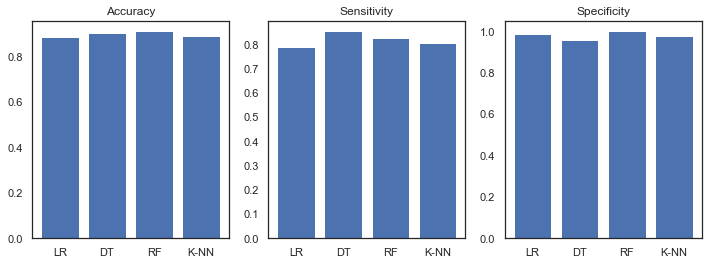

In [48]:
# Create lists of model names and performance values

model_names = ['LR', 'DT', 'RF', 'K-NN']

accuracy = np.asarray([accuracy_lr,
                                  accuracy_dt,
                                  accuracy_rf,
                                  accuracy_knn])
sensitivity =  np.asarray([sensitivity_lr,
                                  sensitivity_dt, 
                                  sensitivity_rf,
                                  sensitivity_knn])
specificity = np.asarray([specificity_lr,
                                  specificity_dt,
                                  specificity_rf,
                                  specificity_knn])

# Create figure and subplots
fig, axs = plt.subplots(1, 3, figsize=(12, 4))

# Create bar chart for accuracy
axs[0].bar(model_names, accuracy)
axs[0].set_title('Accuracy')

# Create bar chart for sensitivity
axs[1].bar(model_names, sensitivity)
axs[1].set_title('Sensitivity')

# Create bar chart for specificity
axs[2].bar(model_names, specificity)
axs[2].set_title('Specificity')

# Show chart
plt.show()


# Hypothetical Example 

In [49]:
df_last.head()

,time_standardized,training_score_standardized,turnover_Stayed
0,0.917581,0.822448,1
1,0.462118,-0.068032,1
2,0.735396,0.043698,1
3,0.462118,1.107176,1
4,0.371025,0.255338,1


In [50]:
df =pd.read_csv('simulated_TECHCO_data.csv')
df = df_last = df.groupby('emp_id', as_index=False).last()
df = df[['time', 'training_score','turnover']]

In [51]:
X_new=[]
mean = [mean_t, mean_tr]
std = [std_t, std_tr]
new = []
n = 2
for i in range(0, n):
    if i == 0:
        print("Enter the time (in months):")
    else:
              print("Enter the training_score: ")
    ele = input()  
    new.append(ele)
for i in range(0, len(new)):
    new[i] = float(new[i])
new[0] = (new[0] - min(df['time']))/max(df['time'])
new[1] = (new[1] - min(df['training_score']))/max(df['training_score'])
for i1, i2, i3 in zip(mean, std, new):
    X_new.append((i3-i1)/i2)
X_new

Enter the time (in months):
35
Enter the training_score: 
4


[0.9560761260558275, 0.28044708277921765]

In [52]:
# Create a scaling and standardization object
scaler = StandardScaler()

# Fit the scaling and standardization object to the original data
scaler.fit(X_train)

# Apply the scaling and standardization transformations to the original data
X_train_scaled = scaler.transform(X_train)

# Create a Random Forest model and fit it to the scaled data
model = RandomForestClassifier()
model.fit(X_train_scaled, Y_train)

X_new = np.array(X_new).reshape(-1, 2)

# Use the model to make predictions on the scaled new data
predictions = model.predict(X_new)

predictions


array([1], dtype=uint8)